In [93]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol

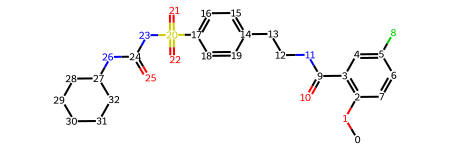

In [102]:
mol = Chem.MolFromSmiles("COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3")
show_atom_number(mol, 'atomLabel')

In [103]:
from rdkit import Chem
# allowable node and edge features
allowable_features = {
    'possible_atomic_num_list': list(range(1, 119)),  #元素周期表序号
    'possible_formal_charge_list': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'possible_chirality_list': [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ],    #原子的手性
    'possible_hybridization_list': [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED
    ],
    'possible_numH_list': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'possible_implicit_valence_list': [0, 1, 2, 3, 4, 5, 6],
    'possible_degree_list': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'possible_bonds': [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ],
    'possible_bond_dirs': [  # only for double bond stereo information
        Chem.rdchem.BondDir.NONE,
        Chem.rdchem.BondDir.ENDUPRIGHT,
        Chem.rdchem.BondDir.ENDDOWNRIGHT
    ],
    'possible_bond_inring': [None, False, True]
}

In [104]:
from MotifGraph import get_mol
import torch
import numpy as np
from MotifGraph import MotifDecomposition
class MolGraph(object):

    def __init__(self, smiles):
        self.smiles = smiles
        self.mol = get_mol(smiles)

        '''
        #Stereo Generation
        mol = Chem.MolFromSmiles(smiles)
        self.smiles3D = Chem.MolToSmiles(mol, isomericSmiles=True)
        self.smiles2D = Chem.MolToSmiles(mol)
        self.stereo_cands = decode_stereo(self.smiles2D)
        '''
        atom_features_list = []
        for atom in self.mol.GetAtoms():
            atom_feature = [allowable_features['possible_atomic_num_list'].index(
                atom.GetAtomicNum())] + [allowable_features[
                                         'possible_degree_list'].index(atom.GetDegree())]

            
            atom_features_list.append(atom_feature)
        self.x_nosuper = torch.tensor(np.array(atom_features_list), dtype=torch.long)

        # bonds
        num_bond_features = 2  # bond type, bond direction
        if len(self.mol.GetBonds()) > 0:  # mol has bonds
            edges_list = []
            edge_features_list = []
            for bond in self.mol.GetBonds():
                i = bond.GetBeginAtomIdx()
                j = bond.GetEndAtomIdx()

                edge_feature = [allowable_features['possible_bonds'].index(
                 bond.GetBondType())] + [allowable_features['possible_bond_inring'].index(
                 bond.IsInRing())]

                edges_list.append((i, j))
                edge_features_list.append(edge_feature)
                edges_list.append((j, i))
                edge_features_list.append(edge_feature)

            # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
            self.edge_index_nosuper = torch.tensor(np.array(edges_list).T, dtype=torch.long)

            # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
            self.edge_attr_nosuper = torch.tensor(np.array(edge_features_list),
                                 dtype=torch.long) 
        else:  
            self.edge_index_nosuper = torch.empty((2, 0), dtype=torch.long) #edgeCOO索引，[[row索引],[col索引]]
            self.edge_attr_nosuper = torch.empty((0, num_bond_features), dtype=torch.long)

        # add super node
        num_atoms = self.x_nosuper.size(0)
        super_x = torch.tensor([[119, 0]]).to(self.x_nosuper.device)  

        #add motif 
        motif_decompose = MotifDecomposition()
        cliques = motif_decompose.defragment(mol = self.mol)
        num_motif = len(cliques)
        if num_motif > 0:
            motif_x = torch.tensor([[120, 0]]).repeat_interleave(num_motif, dim=0).to(self.x_nosuper.device)
            self.x = torch.cat((self.x_nosuper, motif_x, super_x), dim=0)

            motif_edge_index = []
            for k, motif in enumerate(cliques):
                motif_edge_index = motif_edge_index + [[i, num_atoms+k] for i in motif]
            motif_edge_index = torch.tensor(np.array(motif_edge_index).T, dtype=torch.long).to(self.edge_index_nosuper.device)

            super_edge_index = [[num_atoms+i, num_atoms+num_motif] for i in range(num_motif)]
            super_edge_index = torch.tensor(np.array(super_edge_index).T, dtype=torch.long).to(self.edge_index_nosuper.device)
            self.edge_index = torch.cat((self.edge_index_nosuper, motif_edge_index, super_edge_index), dim=1)

            motif_edge_attr = torch.zeros(motif_edge_index.size()[1], 2)
            motif_edge_attr[:,0] = 6 #bond type for self-loop edge
            motif_edge_attr = motif_edge_attr.to(self.edge_attr_nosuper.dtype).to(self.edge_attr_nosuper.device)

            super_edge_attr = torch.zeros(num_motif, 2)
            super_edge_attr[:,0] = 5 #bond type for self-loop edge
            super_edge_attr = super_edge_attr.to(self.edge_attr_nosuper.dtype).to(self.edge_attr_nosuper.device)
            self.edge_attr = torch.cat((self.edge_attr_nosuper, motif_edge_attr, super_edge_attr), dim = 0)

            self.num_part = (num_atoms, num_motif, 1)

        else:
            self.x = torch.cat((self.x_nosuper, super_x), dim=0)

            super_edge_index = [[i, num_atoms] for i in range(num_atoms)]
            super_edge_index = torch.tensor(np.array(super_edge_index).T, dtype=torch.long).to(self.edge_index_nosuper.device)
            self.edge_index = torch.cat((self.edge_index_nosuper, super_edge_index), dim=1)

            super_edge_attr = torch.zeros(num_atoms, 2)
            super_edge_attr[:,0] = 5 #bond type for self-loop edge
            super_edge_attr = super_edge_attr.to(self.edge_attr_nosuper.dtype).to(self.edge_attr_nosuper.device)
            self.edge_attr = torch.cat((self.edge_attr_nosuper, super_edge_attr), dim = 0)

            self.num_part = (num_atoms, 0, 1)


    def size_node(self):
        return self.x.size()[0]

    def size_edge(self):
        return self.edge_attr.size()[0]

    def size_atom(self):
        return self.x_nosuper.size()[0]

    def size_bond(self):
        return self.edge_attr_nosuper.size()[0]

In [105]:
smile = "COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3"
mol = Chem.MolFromSmiles(smile)

In [106]:
mol_graph = MolGraph(smiles = smile)

In [107]:
import torch
from torch.utils.data import Dataset
# from mol_tree import MolTree
import numpy as np
from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from torch_geometric.data import Batch
from torch_geometric.data import Data
from chemutils import get_mol, get_clique_mol


class MoleculeDataset(Dataset):

    def __init__(self, data_file):
        with open(data_file) as f:
            self.data = [line.strip("\r\n ").split()[0] for line in f]
            # print('data',self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        smiles = self.data[idx]
        # print('smiles',smiles)
        mol_graph = MolGraph(smiles)  #motif
        # mol_tree.recover()
        # mol_tree.assemble()
        return mol_graph


In [108]:
dataset = MoleculeDataset('./data/zinc/all.txt')

In [109]:
dataset.__getitem__(0)

In [111]:
# Create a MolGraph object
mol_graph = MolGraph(smile)

# Now you can access the properties of the graph
print("Number of nodes:", mol_graph.size_node())
print("Number of edges:", mol_graph.size_edge())
print("Number of atoms:", mol_graph.size_atom())
print("Number of bonds:", mol_graph.size_bond())

Number of nodes: 44
Number of edges: 113
Number of atoms: 33
Number of bonds: 70


In [112]:
atom_features_list = []
for atom in mol.GetAtoms():
    atom_feature = [allowable_features['possible_atomic_num_list'].index(
        atom.GetAtomicNum())] + [allowable_features[
                                    'possible_degree_list'].index(atom.GetDegree())]

    
    atom_features_list.append(atom_feature)
x_nosuper = torch.tensor(np.array(atom_features_list), dtype=torch.long)

In [113]:
# bonds
num_bond_features = 2  # bond type, bond direction
if len(mol.GetBonds()) > 0:  # mol has bonds
    edges_list = []
    edge_features_list = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        edge_feature = [allowable_features['possible_bonds'].index(
            bond.GetBondType())] + [allowable_features['possible_bond_inring'].index(
            bond.IsInRing())]

        edges_list.append((i, j))
        edge_features_list.append(edge_feature)
        edges_list.append((j, i))
        edge_features_list.append(edge_feature)

    # data.edge_index: Graph connectivity in COO format with shape [2, num_edges]
    edge_index_nosuper = torch.tensor(np.array(edges_list).T, dtype=torch.long)

    # data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
    edge_attr_nosuper = torch.tensor(np.array(edge_features_list),
                            dtype=torch.long) 
else:  
    edge_index_nosuper = torch.empty((2, 0), dtype=torch.long) # edge COO index, [[row index], [column index]]
    edge_attr_nosuper = torch.empty((0, num_bond_features), dtype=torch.long)

In [114]:
num_atoms = x_nosuper.size(0)
super_x = torch.tensor([[119, 0]]).to(x_nosuper.device)  

In [147]:
cliques

[[0, 1],
 [2, 3, 4, 5, 6, 7, 8],
 [9, 10],
 [12, 13],
 [14, 15, 16, 17, 18, 19, 20, 21, 22],
 [24, 25],
 [32, 27, 28, 29, 30, 31],
 [11],
 [23],
 [26]]

In [148]:
#add motif 
motif_decompose = MotifDecomposition()
cliques = motif_decompose.defragment(mol = mol)
num_motif = len(cliques)
if num_motif > 0:
    motif_x = torch.tensor([[120, 0]]).repeat_interleave(num_motif, dim=0).to(x_nosuper.device)
    x = torch.cat((x_nosuper, motif_x, super_x), dim=0)

    motif_edge_index = []
    for k, motif in enumerate(cliques):
        motif_edge_index = motif_edge_index + [[i, num_atoms+k] for i in motif]
    motif_edge_index = torch.tensor(np.array(motif_edge_index).T, dtype=torch.long).to(edge_index_nosuper.device)

    super_edge_index = [[num_atoms+i, num_atoms+num_motif] for i in range(num_motif)]
    super_edge_index = torch.tensor(np.array(super_edge_index).T, dtype=torch.long).to(edge_index_nosuper.device)
    edge_index = torch.cat((edge_index_nosuper, motif_edge_index, super_edge_index), dim=1)

    motif_edge_attr = torch.zeros(motif_edge_index.size()[1], 2)
    motif_edge_attr[:,0] = 6 #bond type for self-loop edge
    motif_edge_attr = motif_edge_attr.to(edge_attr_nosuper.dtype).to(edge_attr_nosuper.device)

    super_edge_attr = torch.zeros(num_motif, 2)
    super_edge_attr[:,0] = 5 #bond type for self-loop edge
    super_edge_attr = super_edge_attr.to(edge_attr_nosuper.dtype).to(edge_attr_nosuper.device)
    edge_attr = torch.cat((edge_attr_nosuper, motif_edge_attr, super_edge_attr), dim = 0)

    num_part = (num_atoms, num_motif, 1)

else:
    x = torch.cat((x_nosuper, super_x), dim=0)

    super_edge_index = [[i, num_atoms] for i in range(num_atoms)]
    super_edge_index = torch.tensor(np.array(super_edge_index).T, dtype=torch.long).to(edge_index_nosuper.device)
    edge_index = torch.cat((edge_index_nosuper, super_edge_index), dim=1)

    super_edge_attr = torch.zeros(num_atoms, 2)
    super_edge_attr[:,0] = 5 #bond type for self-loop edge
    super_edge_attr = super_edge_attr.to(edge_attr_nosuper.dtype).to(edge_attr_nosuper.device)
    edge_attr = torch.cat((edge_attr_nosuper, super_edge_attr), dim = 0)

    num_part = (num_atoms, 0, 1)

In [149]:
motif_edge_index

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 24, 25, 32, 27, 28, 29, 30, 31, 11, 23, 26],
        [33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 36, 36, 37, 37, 37, 37, 37,
         37, 37, 37, 37, 38, 38, 39, 39, 39, 39, 39, 39, 40, 41, 42]])

In [140]:
motif_edge_index = []
for k, motif in enumerate(cliques):
    print(k , motif)
    print('-----')
    motif_edge_index = motif_edge_index + [[i, num_atoms+k] for i in motif]
    for i in motif:
        print(i, num_atoms+k)
    print('----')

0 [0, 1]
-----
0 33
1 33
----
1 [2, 3, 4, 5, 6, 7, 8]
-----
2 34
3 34
4 34
5 34
6 34
7 34
8 34
----
2 [9, 10]
-----
9 35
10 35
----
3 [12, 13]
-----
12 36
13 36
----
4 [14, 15, 16, 17, 18, 19, 20, 21, 22]
-----
14 37
15 37
16 37
17 37
18 37
19 37
20 37
21 37
22 37
----
5 [24, 25]
-----
24 38
25 38
----
6 [32, 27, 28, 29, 30, 31]
-----
32 39
27 39
28 39
29 39
30 39
31 39
----
7 [11]
-----
11 40
----
8 [23]
-----
23 41
----
9 [26]
-----
26 42
----


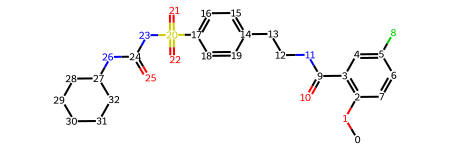

In [120]:
mol = Chem.MolFromSmiles("COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3")
show_atom_number(mol, 'atomLabel')